In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from vae.vae import VAE
from vae.train_vae import ImageDataset

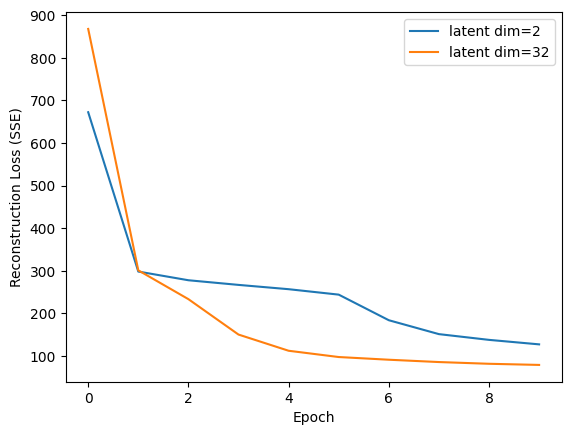

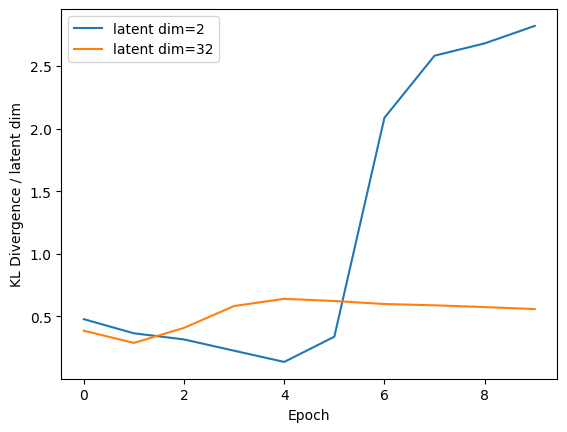

In [5]:
def plot_losses():
    small_df = pd.read_csv("models/smallhumanvae_results.csv")
    car_df = pd.read_csv("models/humanvae_results.csv")

    plt.plot(range(len(small_df)), small_df["recons"], label="latent dim=2")
    plt.plot(range(len(car_df)), car_df["recons"], label="latent dim=32")
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Loss (SSE)")
    plt.legend()
    plt.show()

    plt.plot(range(len(small_df)), small_df["klds"] / 2, label="latent dim=2")
    plt.plot(range(len(car_df)), car_df["klds"] / 32, label="latent dim=32")
    plt.xlabel("Epoch")
    plt.ylabel("KL Divergence / latent dim")
    plt.legend()
    plt.show()

plot_losses()

In [6]:
def unprocess_img(tens: torch.Tensor):
    """
    tens: (C H W)
    """
    img = tens.clone()
    img = img.permute(1, 2, 0)
    img = img * 255
    img = img.numpy().astype(int)
    return img


def visualize(vaes: list[VAE], dataset: ImageDataset, n_imgs: int):
    for vae in vaes:
        vae.eval()
    img_idxs = np.random.choice(len(dataset), n_imgs, replace=False)
    with torch.no_grad():
        for i in img_idxs:
            fig, ax = plt.subplots(1, len(vaes)+1)
            img, _ = dataset[i]
            ax[0].imshow(unprocess_img(img))

            img = img.unsqueeze(0)

            for i, vae in enumerate(vaes):
                recon = vae(img)[0][0]
                ax[i+1].imshow(unprocess_img(recon))
            plt.show()


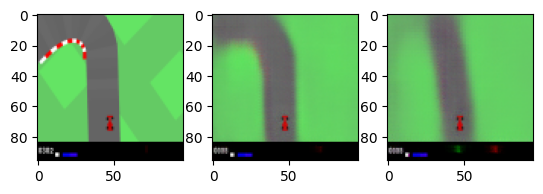

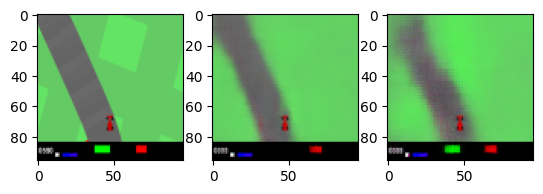

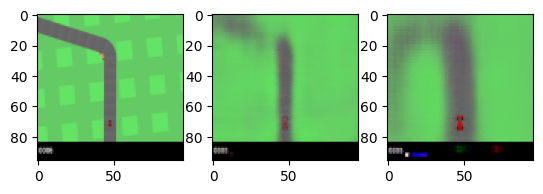

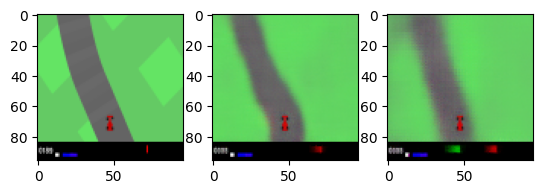

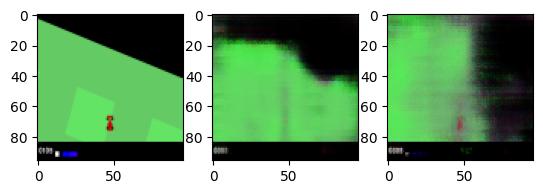

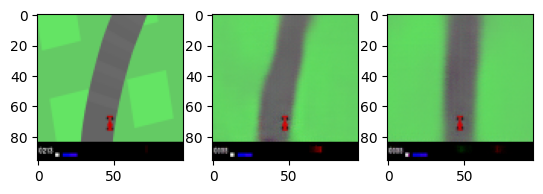

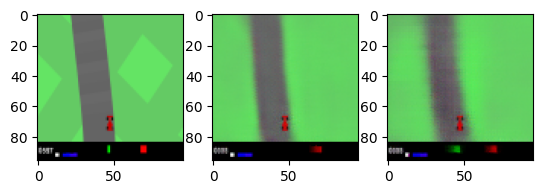

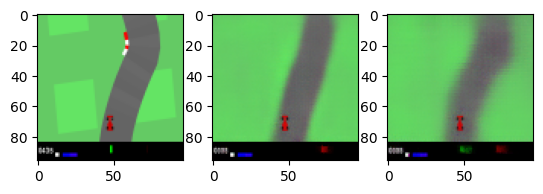

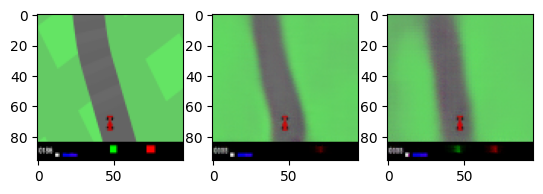

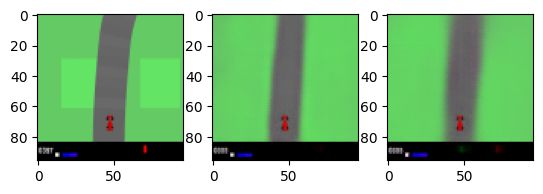

In [10]:
with open("config.json", "r", encoding="utf-8") as f:
    config = json.load(f)

vae = VAE(config["img_size"], config["latent_dim"], config["encoder_blocks"], config["decoder_blocks"])
vae.load_state_dict(torch.load("models/humanvae.pt", weights_only=True))

small = VAE(config["img_size"], 2, config["encoder_blocks"], config["decoder_blocks"])
small.load_state_dict(torch.load("models/smallhumanvae.pt", weights_only=True))

dataset = ImageDataset("data/CarRacing-v2/human-test.npy")

visualize([vae, small], dataset, n_imgs=10)

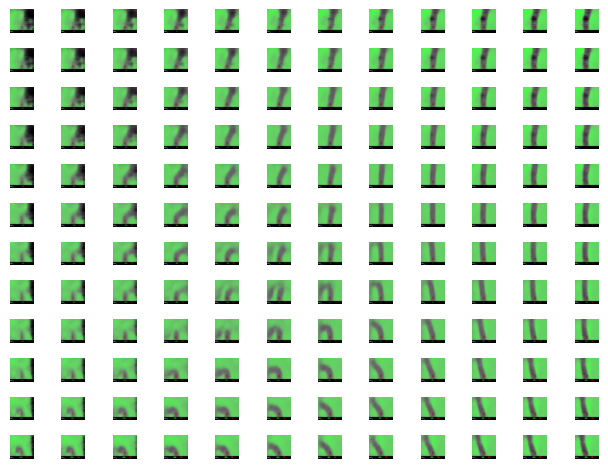

In [9]:
def plot_2d_space(vae: VAE):
    vae.eval()
    with torch.no_grad():
        step_size = 0.5
        z1s = np.arange(-3, 3, step_size)
        z2s = np.arange(-3, 3, step_size)
        fig, ax = plt.subplots(len(z1s), len(z2s), tight_layout=True)
        for i, z1 in enumerate(z1s):
            for j, z2 in enumerate(z2s):
                z = torch.tensor([z1, z2], dtype=torch.float32).unsqueeze(0)
                recon = vae.decode(z)
                ax[i, j].imshow(unprocess_img(recon[0]))
                ax[i, j].axis("off")

    plt.show()

plot_2d_space(small)